In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

engine  = create_engine("postgresql+psycopg2://localhost/ecommerce_analytics")

In [2]:
monthly_kpis = pd.read_sql("select * from mart_monthly_kpis order by month", engine)
monthly_kpis.head()

,month,orders,unique_customers,revenue,aov,orders_per_customer
0,2016-09-01,3,3,354.75,118.25,1.00
1,2016-10-01,308,305,56808.84,184.44,1.01
2,2016-12-01,1,1,19.62,19.62,1.00
3,2017-01-01,789,755,137188.49,173.88,1.05
4,2017-02-01,1733,1708,286280.62,165.19,1.01


In [3]:
cohort_retention = pd.read_sql(
    "SELECT * FROM mart_cohort_retention ORDER BY cohort_month, month_number;",
    engine
)
cohort_retention.head()

,cohort_month,month_number,active_customers,cohort_size,retention_pct
0,2016-09-01,0,4,4,100.00
1,2016-10-01,0,321,321,100.00
2,2016-10-01,6,1,321,0.31
3,2016-10-01,9,1,321,0.31
4,2016-10-01,11,1,321,0.31


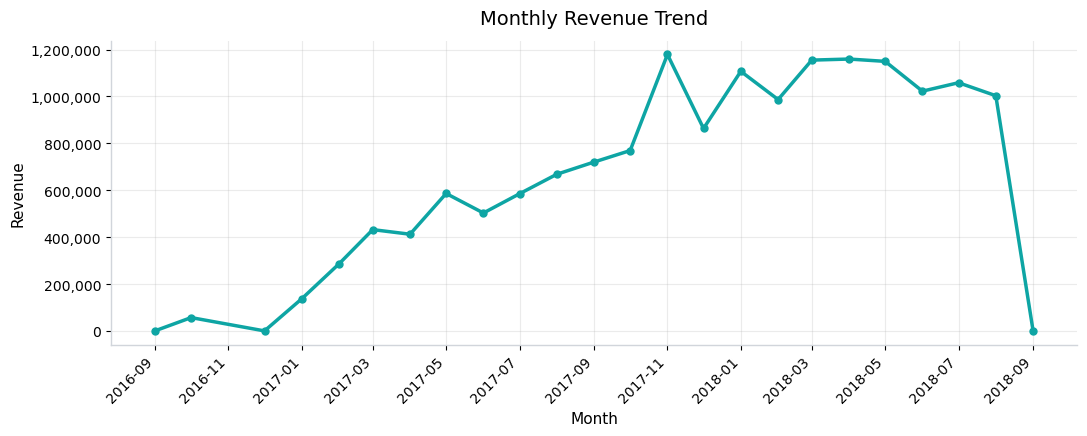

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

TEAL = "#0EA5A4"

def format_time_axis(ax, interval=2):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")

def format_axes(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.25)

def plot_monthly_revenue(monthly_kpis):
    df = monthly_kpis.copy()
    df["month"] = pd.to_datetime(df["month"])

    fig, ax = plt.subplots(figsize=(11, 4.5))
    ax.plot(df["month"], df["revenue"], color=TEAL)

    format_time_axis(ax, interval=2)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    format_axes(ax, "Monthly Revenue Trend", "Month", "Revenue")

    plt.tight_layout()
    plt.show()

plot_monthly_revenue(monthly_kpis)

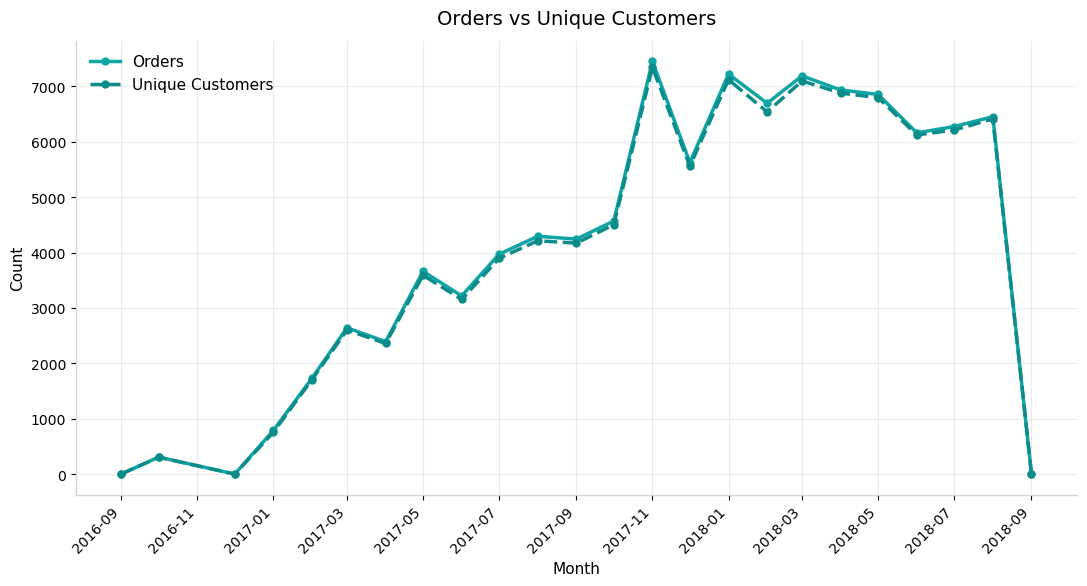

In [14]:
def plot_orders_vs_customers(monthly_kpis):
    df = monthly_kpis.copy()
    df["month"] = pd.to_datetime(df["month"])

    fig, ax = plt.subplots(figsize=(11, 6))

    # Orders = solid teal
    ax.plot(
        df["month"],
        df["orders"],
        color=TEAL,
        linestyle="-",
        linewidth=2.5,
        label="Orders"
    )

    # Unique Customers = dashed darker teal
    ax.plot(
        df["month"],
        df["unique_customers"],
        color="#0B8B8A",
        linestyle="--",
        linewidth=2.5,
        label="Unique Customers"
    )

    format_time_axis(ax, interval=2)
    format_axes(ax, "Orders vs Unique Customers", "Month", "Count")
    ax.legend()

    plt.tight_layout()
    plt.show()
plot_orders_vs_customers(monthly_kpis)

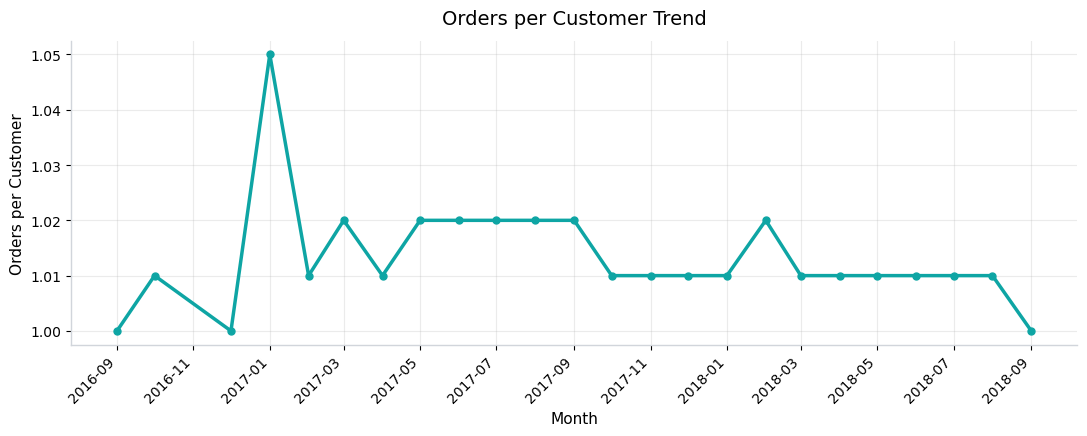

In [15]:
def plot_orders_per_customer(monthly_kpis):
    df = monthly_kpis.copy()
    df["month"] = pd.to_datetime(df["month"])

    fig, ax = plt.subplots(figsize=(11, 4.5))
    ax.plot(df["month"], df["orders_per_customer"], color=TEAL)

    format_time_axis(ax, interval=2)
    format_axes(ax, "Orders per Customer Trend", "Month", "Orders per Customer")

    plt.tight_layout()
    plt.show()
plot_orders_per_customer(monthly_kpis)

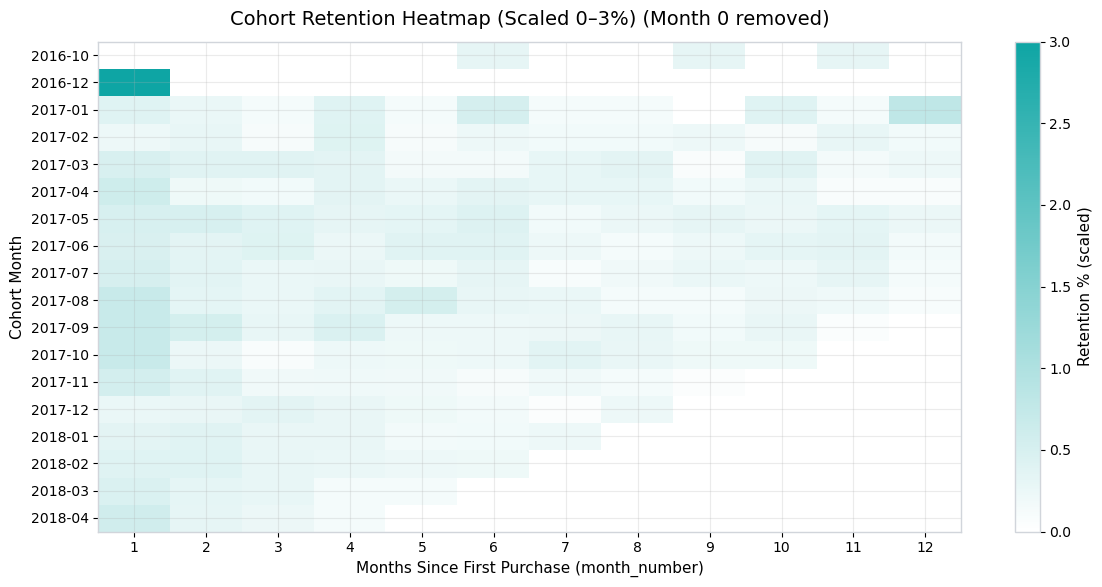

In [22]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

TEAL = "#0EA5A4"

def plot_cohort_heatmap(cohort_retention, max_cohorts=18, max_months=12, vmax=3, drop_month0=True):
    """
    Cohort retention heatmap optimized for low retention values.

    Parameters:
    - max_cohorts: how many cohort rows to show (keeps chart readable)
    - max_months: how many months to show on x-axis
    - vmax: upper cap for color scale (ex: 3 means scale is 0–3%)
    - drop_month0: removes month 0 (100%) so other months are visible
    """

    df = cohort_retention.copy()
    df["cohort_month"] = pd.to_datetime(df["cohort_month"])

    # Optional: remove month 0 because it is always 100%
    if drop_month0:
        df = df[df["month_number"] != 0]

    # Limit to first N months
    df = df[df["month_number"] <= max_months]

    # Pivot table
    pivot = df.pivot_table(
        index="cohort_month",
        columns="month_number",
        values="retention_pct",
        aggfunc="mean"
    ).fillna(0)

    # Keep cohorts readable
    pivot = pivot.sort_index().head(max_cohorts)

    # Teal-only colormap + scaling
    teal_cmap = LinearSegmentedColormap.from_list("teal_cmap", ["#FFFFFF", TEAL])
    norm = Normalize(vmin=0, vmax=vmax)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(pivot.values, aspect="auto", cmap=teal_cmap, norm=norm)

    title_suffix = f"(Scaled 0–{vmax}%)"
    if drop_month0:
        title_suffix += " (Month 0 removed)"

    ax.set_title(f"Cohort Retention Heatmap {title_suffix}")
    ax.set_xlabel("Months Since First Purchase (month_number)")
    ax.set_ylabel("Cohort Month")

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)

    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([d.strftime("%Y-%m") for d in pivot.index])

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Retention % (scaled)")

    plt.tight_layout()
    plt.show()
plot_cohort_heatmap(cohort_retention, vmax=3)

# If retention is extremely low, try:
# plot_cohort_heatmap(cohort_retention, vmax=2)

# If you want more variation, try:
# plot_cohort_heatmap(cohort_retention, vmax=5)


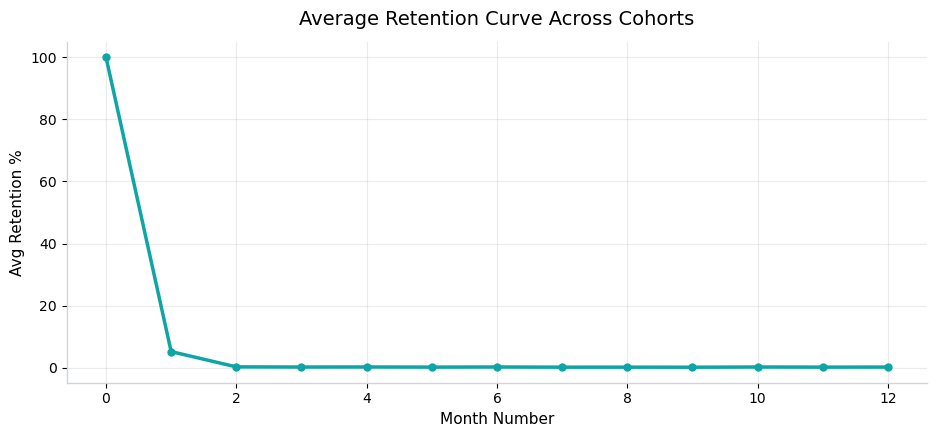

In [23]:
def plot_avg_retention_curve(cohort_retention, max_months=12):
    df = cohort_retention.copy()
    df = df[df["month_number"] <= max_months]

    avg_ret = df.groupby("month_number")["retention_pct"].mean().reset_index()

    fig, ax = plt.subplots(figsize=(9.5, 4.5))
    ax.plot(avg_ret["month_number"], avg_ret["retention_pct"], color=TEAL)

    format_axes(ax, "Average Retention Curve Across Cohorts", "Month Number", "Avg Retention %")

    plt.tight_layout()
    plt.show()
plot_avg_retention_curve(cohort_retention)

In [26]:
#Top Categories Revenue Chart
top_categories_query = """
SELECT
  COALESCE(t.product_category_name_english, p.product_category_name) AS category,
  SUM(oi.price + oi.freight_value) AS revenue
FROM order_items oi
JOIN products p ON p.product_id = oi.product_id
LEFT JOIN category_translation t
  ON t.product_category_name = p.product_category_name
GROUP BY 1
ORDER BY revenue DESC
LIMIT 15;
"""

top_categories = pd.read_sql(top_categories_query, engine)
top_categories.head()

,category,revenue
0,health_beauty,1441248.07
1,watches_gifts,1305541.61
2,bed_bath_table,1241681.72
3,sports_leisure,1156656.48
4,computers_accessories,1059272.40


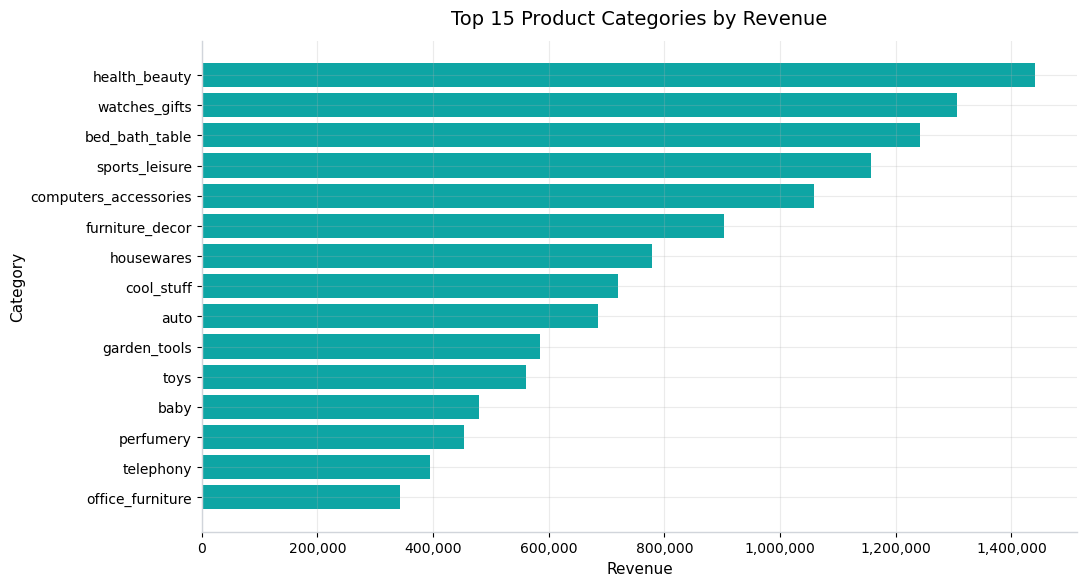

In [27]:
def plot_top_categories(top_categories):
    df = top_categories.copy().sort_values("revenue")

    fig, ax = plt.subplots(figsize=(11, 6))
    ax.barh(df["category"], df["revenue"], color=TEAL)

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    format_axes(ax, "Top 15 Product Categories by Revenue", "Revenue", "Category")

    plt.tight_layout()
    plt.show()

plot_top_categories(top_categories)